
=== Final Comparison ===
              Coin   Naive_RMSE    Naive_MAE ARIMA_Order    ARIMA_RMSE  \
0             Aave    32.661270    22.631275   (2, 1, 2)    283.594356   
1      BinanceCoin    30.701275    19.400477   (0, 1, 0)    319.652600   
2          Bitcoin  2129.380632  1594.858475   (0, 2, 1)  13469.552720   
3          Cardano     0.099808     0.065600   (1, 1, 2)      1.059536   
4        ChainLink     2.588693     1.870587   (2, 1, 2)     19.278092   
5           Cosmos     1.537238     1.086966   (0, 1, 1)     11.779032   
6    CryptocomCoin     0.012471     0.007875   (1, 0, 0)      0.095093   
7         Dogecoin     0.035929     0.018765   (1, 0, 1)      0.244698   
8              EOS     0.734611     0.378869   (2, 1, 2)      3.237862   
9         Ethereum   154.621994   104.097358   (1, 2, 2)   1472.086812   
10            Iota     0.123891     0.083120   (2, 1, 2)      1.106401   
11        Litecoin    16.232432    10.486743   (2, 1, 2)     95.325709   
12          

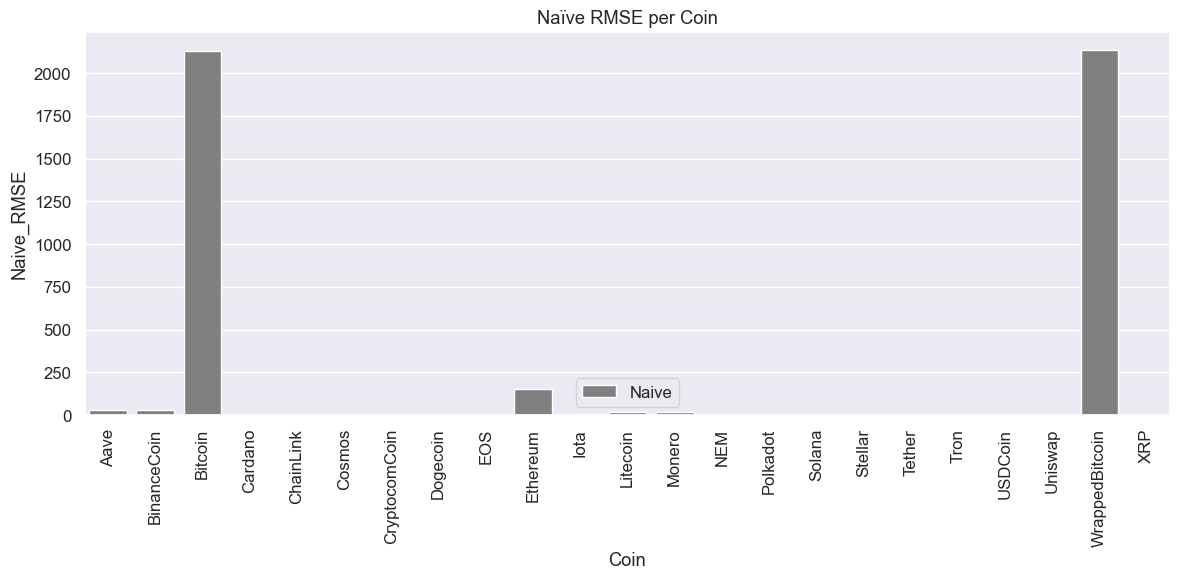

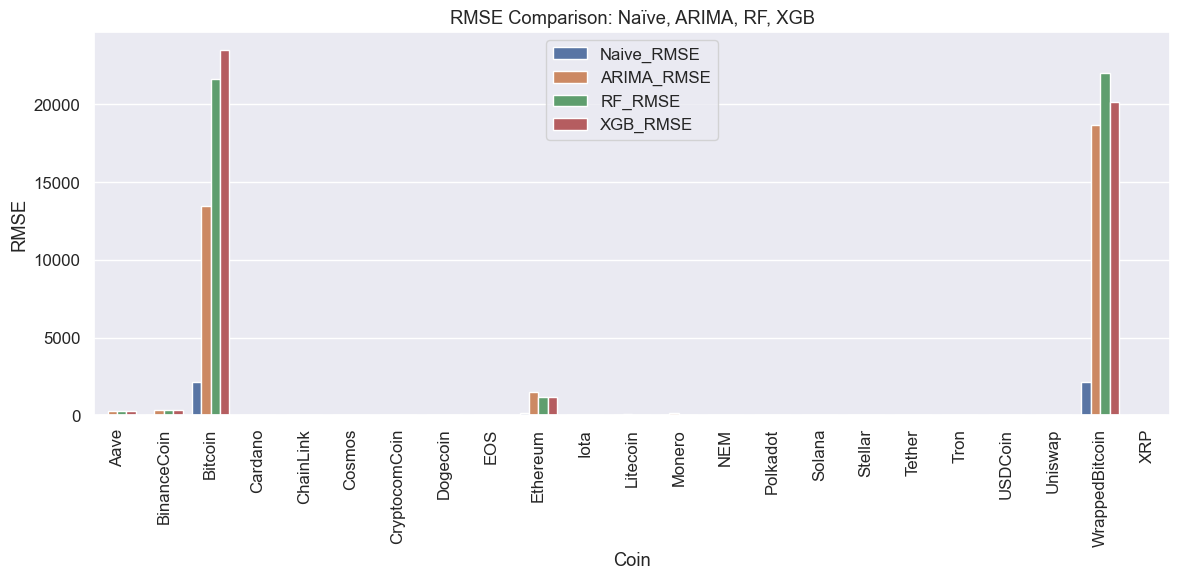

In [1]:
# 06_final_comparison.ipynb

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=1.1)

DATA_FOLDER = '../data'

# 1. Load baseline (ARIMA vs. Naive) results
baseline_csv = os.path.join(DATA_FOLDER, 'baseline_results_statsmodels.csv')
baseline_df = pd.read_csv(baseline_csv)

# 2. Load advanced model (RF vs. XGB) results
advanced_csv = os.path.join(DATA_FOLDER, 'advanced_model_results.csv')
advanced_df = pd.read_csv(advanced_csv)

# 3. Merge on 'Coin'
merged = pd.merge(baseline_df, advanced_df, on='Coin', how='outer')

"""
merged columns might look like:
['Coin', 'Naive_RMSE', 'Naive_MAE', 'ARIMA_Order', 'ARIMA_RMSE', 'ARIMA_MAE',
 'RF_RMSE', 'RF_MAE', 'XGB_RMSE', 'XGB_MAE']
"""

print("\n=== Final Comparison ===")
print(merged)

# 4. Example: Bar plot of each coin's best RMSE
plt.figure(figsize=(12,6))
sns.barplot(data=merged, x='Coin', y='Naive_RMSE', color='gray', label='Naive')
# Could stack or overlay bars for ARIMA_RMSE, RF_RMSE, XGB_RMSE
# But barplot isn't ideal for multi-series. 
# Instead, a pivot or side-by-side might be better.

plt.xticks(rotation=90)
plt.title("Naïve RMSE per Coin")
plt.legend()
plt.tight_layout()
plt.show()

# 5. You can do more advanced plots: create a melted DataFrame
melt_cols = ['Naive_RMSE','ARIMA_RMSE','RF_RMSE','XGB_RMSE']
melt_df = merged.melt(id_vars=['Coin'], value_vars=melt_cols, var_name='Model', value_name='RMSE')

plt.figure(figsize=(12,6))
sns.barplot(data=melt_df, x='Coin', y='RMSE', hue='Model')
plt.xticks(rotation=90)
plt.title("RMSE Comparison: Naïve, ARIMA, RF, XGB")
plt.legend()
plt.tight_layout()
plt.show()
